Redes Neuronales Recurrentes (RNN)

Importar bibliotecas y montar Google Drive

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Cargar y preprocesar el dataset

In [15]:
data_path = '/content/drive/MyDrive/IA2/datasets/TSLA.csv'
data = pd.read_csv(data_path)

prices = data['Adj Close'].values.reshape(-1, 1)

# Normalizar los datos
scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices)

# Crear secuencias
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(data[i+seq_length])
    return np.array(xs), np.array(ys)

seq_length = 30  # Ventana de 30 días (como en tu ejemplo)
X, y = create_sequences(prices_scaled, seq_length)

# Dividir en train (80%), test (20%)
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Convertir a tensores
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Crear DataLoaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
dataloader = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True),
    'test': DataLoader(test_dataset, batch_size=32, shuffle=False)
}

print(f'Train shape: {X_train.shape}, {y_train.shape}')
print(f'Test shape: {X_test.shape}, {y_test.shape}')

Train shape: torch.Size([1908, 30, 1]), torch.Size([1908, 1])
Test shape: torch.Size([478, 30, 1]), torch.Size([478, 1])


Función para graficar series

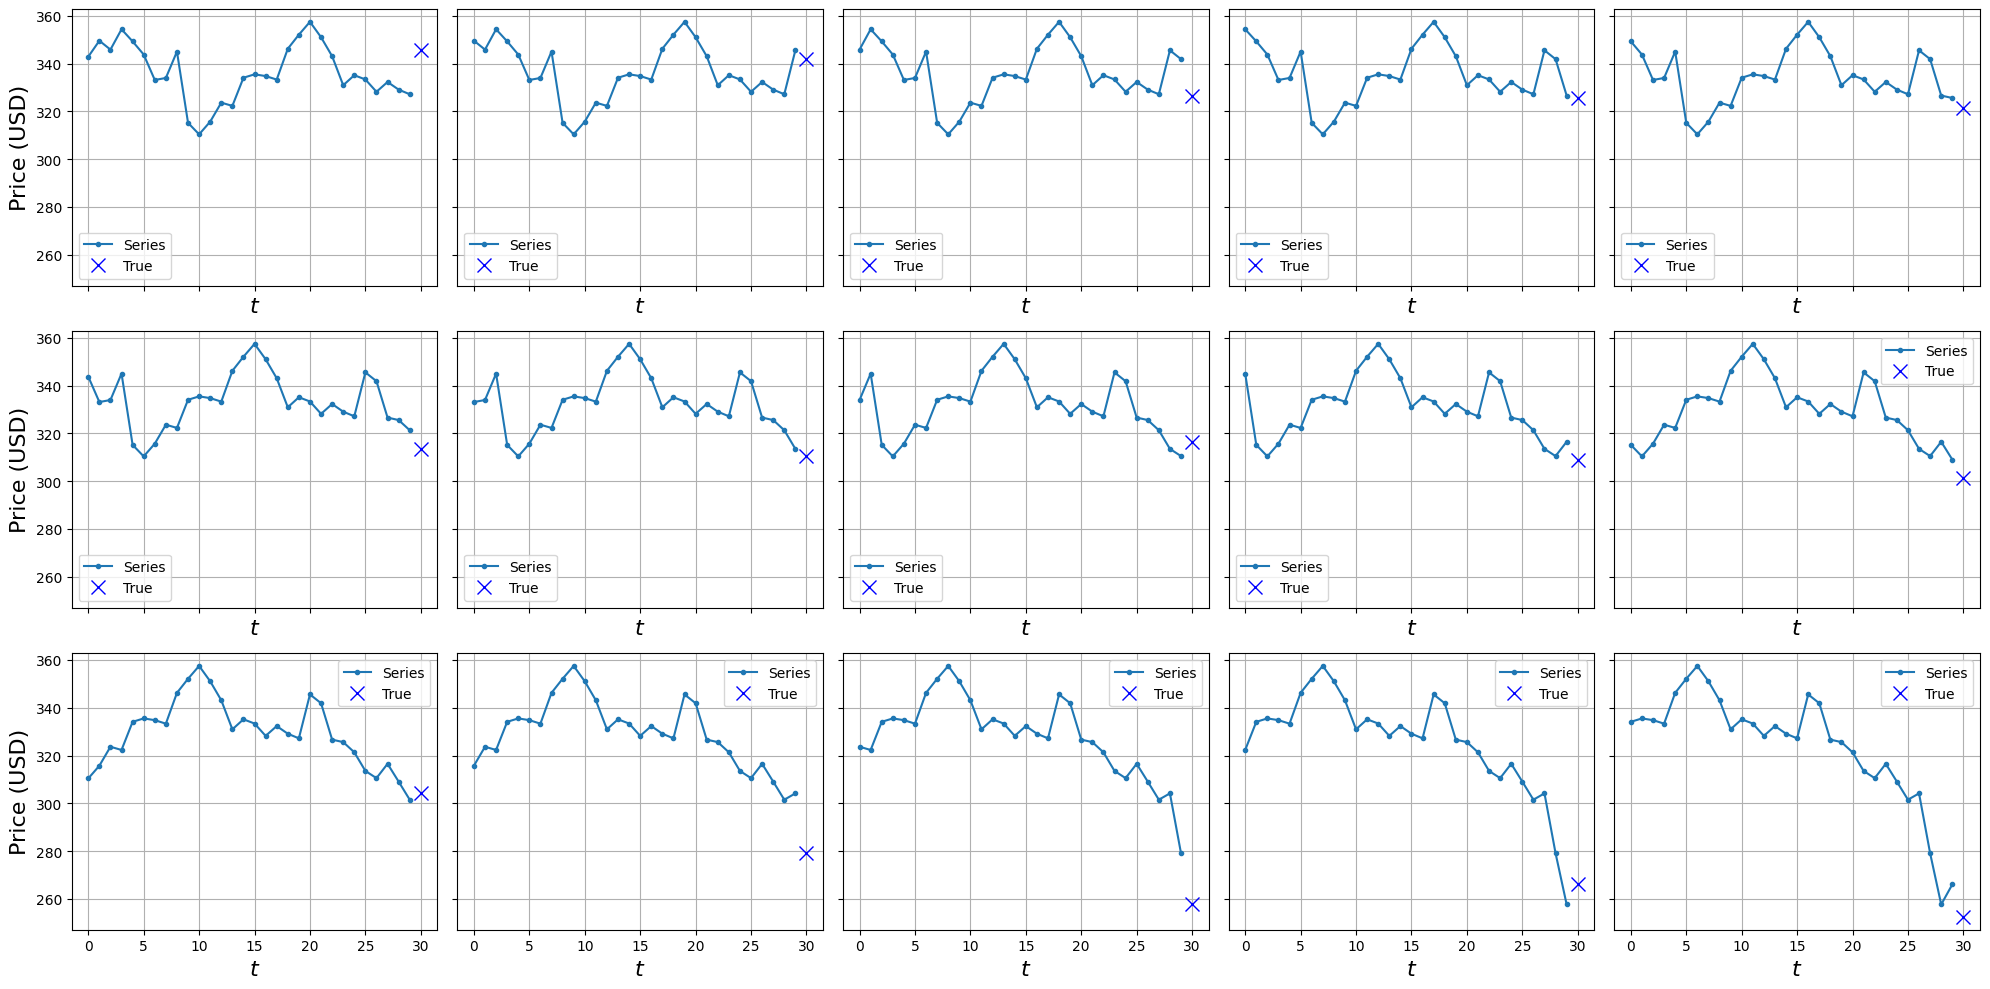

In [16]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="Price (USD)"):
    r, c = 3, 5
    fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
    for row in range(r):
        for col in range(c):
            plt.sca(axes[row][col])
            ix = col + row * c
            if ix < len(series):
                series_unscaled = scaler.inverse_transform(series[ix].reshape(-1, 1)).flatten()
                plt.plot(series_unscaled, ".-", label="Series")
                if y is not None:
                    y_unscaled = scaler.inverse_transform(y[ix].reshape(-1, 1)).flatten()
                    plt.plot(range(len(series_unscaled), len(series_unscaled)+1), y_unscaled, "bx", markersize=10, label="True")
                if y_pred is not None:
                    y_pred_unscaled = scaler.inverse_transform(y_pred[ix].reshape(-1, 1)).flatten()
                    plt.plot(range(len(series_unscaled), len(series_unscaled)+1), y_pred_unscaled, "ro", label="Predicted")
                plt.grid(True)
                plt.legend()
                plt.xlabel(x_label, fontsize=16)
                if col == 0:
                    plt.ylabel(y_label, fontsize=16, rotation=90)
    plt.tight_layout()
    plt.show()

# Graficar algunas series de prueba
plot_series(X_test[:15], y_test[:15])

Definir el modelo RNN

In [17]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=40, output_size=1):
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, h = self.rnn(x)
        y = self.fc(x[:, -1])  # Solo la última salida
        return y

# Instanciar el modelo
rnn = SimpleRNN()
print('Parámetros del modelo:')
print(f'W_ih: {rnn.rnn.weight_ih_l0.shape}, W_hh: {rnn.rnn.weight_hh_l0.shape}')
print(f'b_ih: {rnn.rnn.bias_ih_l0.shape}, b_hh: {rnn.rnn.bias_hh_l0.shape}')
print(f'Linear: {rnn.fc.weight.shape}, {rnn.fc.bias.shape}')

Parámetros del modelo:
W_ih: torch.Size([40, 1]), W_hh: torch.Size([40, 40])
b_ih: torch.Size([40]), b_hh: torch.Size([40])
Linear: torch.Size([1, 40]), torch.Size([1])


Función para entrenar el modelo

In [18]:
def fit(model, dataloader, epochs=50):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    loss_function = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in dataloader['train']:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_function(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
        train_loss /= len(dataloader['train'].dataset)

        if epoch % 10 == 0:
            print(f'Epoch {epoch}: Train Loss = {train_loss:.6f}')

# Entrenar el modelo
fit(rnn, dataloader, epochs=50)

Epoch 0: Train Loss = 0.008743
Epoch 10: Train Loss = 0.000098
Epoch 20: Train Loss = 0.000088
Epoch 30: Train Loss = 0.000080
Epoch 40: Train Loss = 0.000068


Prediccion y evaluacion

Test MSE (scaled): 0.000332
Test MSE (unscaled): 193.71 USD²
R² Score: 0.9628
MAPE: 2.78%
Porcentaje de acierto (±5%): 85.77%


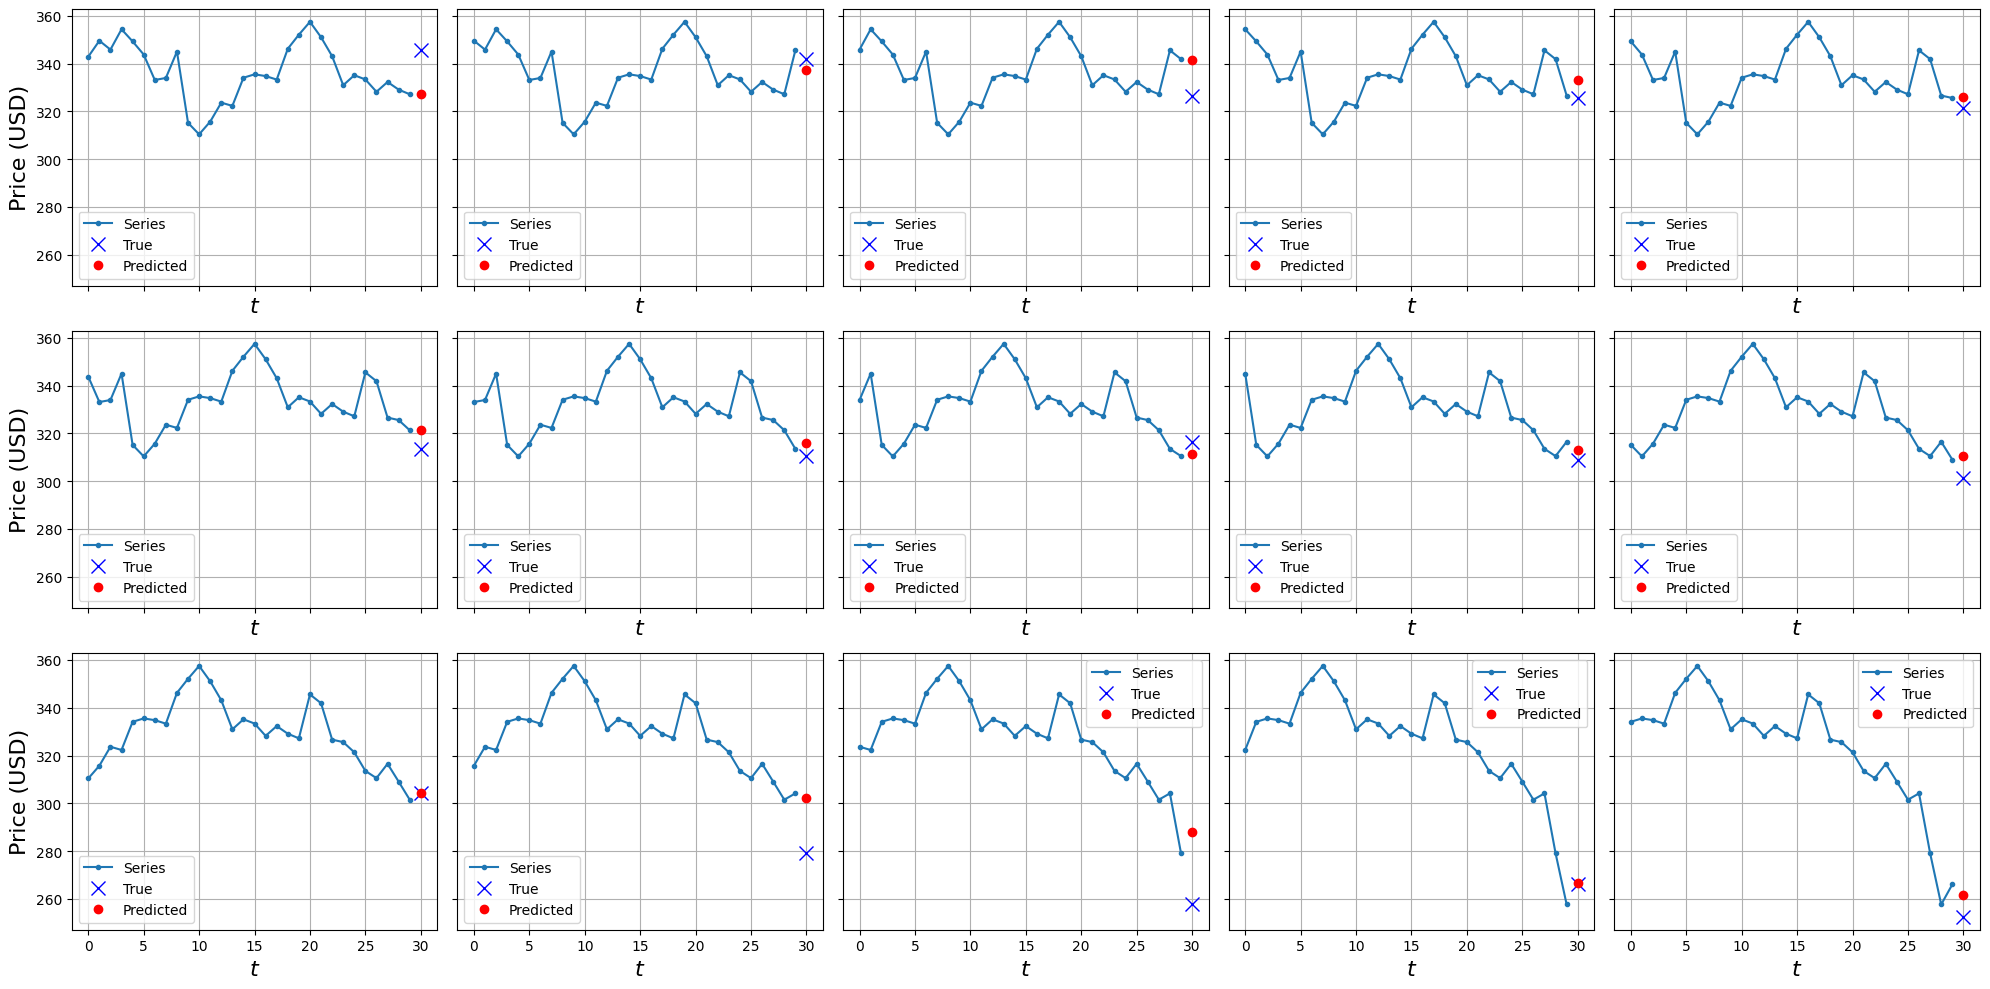

In [19]:
def predict(model, dataloader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    predictions = []
    with torch.no_grad():
        for X_batch, _ in dataloader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch)
            predictions.append(y_pred.cpu().numpy())
    return np.concatenate(predictions)

# Predicciones en test
y_pred = predict(rnn, dataloader['test'])

# Calcular métricas
y_test_unscaled = scaler.inverse_transform(y_test.numpy())
y_pred_unscaled = scaler.inverse_transform(y_pred)

# MSE
mse_scaled = mean_squared_error(y_test.numpy(), y_pred)
mse_unscaled = mean_squared_error(y_test_unscaled, y_pred_unscaled)
print(f'Test MSE (scaled): {mse_scaled:.6f}')
print(f'Test MSE (unscaled): {mse_unscaled:.2f} USD²')

# R²
r2 = r2_score(y_test_unscaled, y_pred_unscaled)
print(f'R² Score: {r2:.4f}')

# MAPE (Error Absoluto Medio Porcentual)
mape = np.mean(np.abs((y_test_unscaled - y_pred_unscaled) / y_test_unscaled)) * 100
print(f'MAPE: {mape:.2f}%')

# Porcentaje de acierto (predicciones dentro de ±5% del valor real)
tolerance = 0.05  # 5% de tolerancia
errors = np.abs((y_test_unscaled - y_pred_unscaled) / y_test_unscaled)
accurate_predictions = np.sum(errors <= tolerance)
accuracy_percentage = (accurate_predictions / len(y_test_unscaled)) * 100
print(f'Porcentaje de acierto (±5%): {accuracy_percentage:.2f}%')

# Graficar predicciones
plot_series(X_test[:15], y_test[:15], y_pred[:15])

Predicciones 5 dias

In [20]:
def predict_future(model, last_sequence, num_predictions, scaler, device='cpu'):
    model.to(device)
    model.eval()
    predictions = []
    current_sequence = last_sequence.clone().detach().to(device)
    with torch.no_grad():
        for _ in range(num_predictions):
            y_pred = model(current_sequence.unsqueeze(0))
            predictions.append(y_pred.cpu().numpy())
            current_sequence = torch.cat((current_sequence[1:], y_pred), dim=0)
    predictions = np.concatenate(predictions)
    return scaler.inverse_transform(predictions)

# Predicciones futuras
last_sequence = X_test[-1]
future_predictions = predict_future(rnn, last_sequence, num_predictions=5, scaler=scaler)
print('Predicciones futuras (30 días después del último dato):')
for i, pred in enumerate(future_predictions):
    print(f'Día {i+1}: ${pred[0]:.2f}')

Predicciones futuras (5 días después del último dato):
Día 1: $634.99
Día 2: $632.91
Día 3: $624.84
Día 4: $616.77
Día 5: $610.20
